<a href="https://colab.research.google.com/github/OswaldVc/Arduino/blob/main/T_test_con_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install pingouin

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg

In [4]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/births.csv')
datos = pd.read_csv(url, sep=',')
datos.head(4)

,f_age,m_age,weeks,premature,visits,gained,weight,sex_baby,smoke
0,31.0,30,39,full term,13.0,1.0,6.88,male,smoker
1,34.0,36,39,full term,5.0,35.0,7.69,male,nonsmoker
2,36.0,35,40,full term,12.0,29.0,8.88,male,nonsmoker
3,41.0,40,40,full term,13.0,30.0,9.00,female,nonsmoker


In [5]:
# Número de observaciones por grupo
# ==============================================================================
datos.groupby('smoke').size()

smoke
nonsmoker    100
smoker        50
dtype: int64

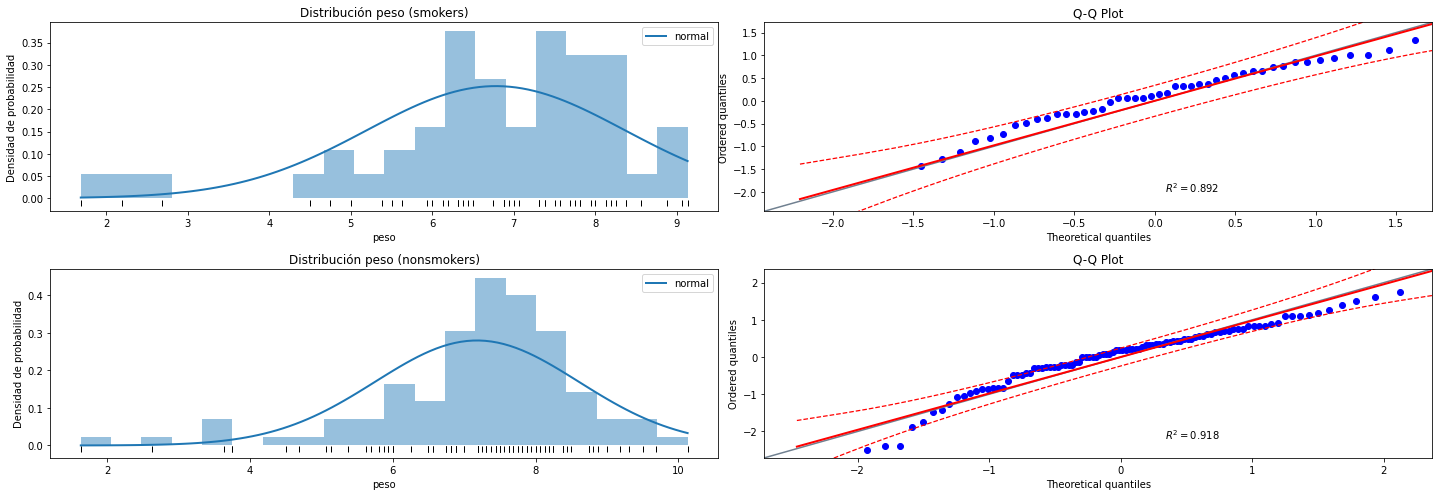

In [7]:
# Gráficos de distribución
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(20, 7))

peso_smokers = datos.loc[datos.smoke == 'smoker', 'weight']
# Valores de la media (mu) y desviación típica (sigma) de cada grupo
mu, sigma = stats.norm.fit(peso_smokers)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(peso_smokers), max(peso_smokers), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico distribución
axs[0, 0].plot(x_hat, y_hat, linewidth=2, label='normal')
axs[0, 0].hist(x=peso_smokers, density=True, bins=20, color="#3182bd", alpha=0.5)
axs[0, 0].plot(peso_smokers, np.full_like(peso_smokers, -0.01), '|k', markeredgewidth=1)
axs[0, 0].set_title('Distribución peso (smokers)')
axs[0, 0].set_xlabel('peso')
axs[0, 0].set_ylabel('Densidad de probabilidad')
axs[0, 0].legend()

# Gráfico distribución qq-plot
pg.qqplot(peso_smokers, dist='norm', ax=axs[0, 1])

peso_nonsmokers = datos.loc[datos.smoke == 'nonsmoker', 'weight']
mu, sigma = stats.norm.fit(peso_nonsmokers)
x_hat = np.linspace(min(peso_nonsmokers), max(peso_nonsmokers), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)
axs[1, 0].plot(x_hat, y_hat, linewidth=2, label='normal')
axs[1, 0].hist(x=peso_nonsmokers, density=True, bins=20, color="#3182bd", alpha=0.5)
axs[1, 0].plot(peso_nonsmokers, np.full_like(peso_nonsmokers, -0.01), '|k', markeredgewidth=1)
axs[1, 0].set_title('Distribución peso (nonsmokers)')
axs[1, 0].set_xlabel('peso')
axs[1, 0].set_ylabel('Densidad de probabilidad')
axs[1, 0].legend()

pg.qqplot(peso_nonsmokers, dist='norm', ax=axs[1, 1])
plt.tight_layout();

In [8]:
# Test de normalidad Shapiro-Wilk
# ==============================================================================
pg.normality(data=datos, dv='weight', group='smoke')

,W,pval,normal
smoker,0.894906,0.000328,False
nonsmoker,0.923736,0.000022,False


Los gráficos cuantil-cuantil muestran asimetría hacia la izquierda y el test Shapiro-Wilk encuentran evidencias significativas de que los datos no proceden de poblaciones con distribución normal. Sin embargo, dado que el tamaño de cada grupo es mayor que 30 se puede considerar que el t-test sigue siendo suficientemente robusto, aunque es necesario mencionarlo en las conclusiones. Una alternativa es recurrir a test no paramétrico basado en la mediana (Mann-Withney-Wilcoxon test) o un test de Bootstraping serían más adecuados. Otra opción es estudiar si los datos anómalos son excepciones que se pueden excluir del análisis.

***Igualdad de varianza (homocedasticidad)***

Existen varios test que permiten comparar varianzas. Dado que no se cumple el criterio de normalidad, uno de los recomendados es el test de Leven.

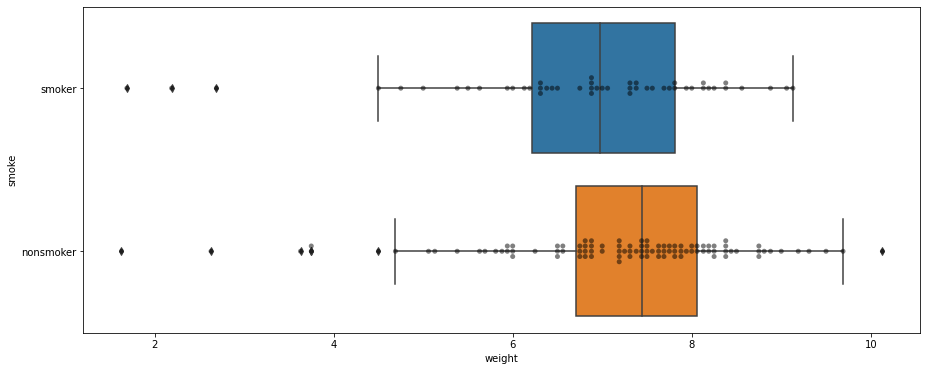

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(y="smoke", x="weight", data=datos, ax=ax)
sns.swarmplot(y="smoke", x="weight", data=datos, color='black', alpha = 0.5, ax=ax);

In [11]:
# Test de homocedasticidad
# ==============================================================================
pg.homoscedasticity(data=datos, dv='weight', group='smoke')

,W,pval,equal_var
levene,0.444176,0.506151,True


No se encuentran evidencias significativas (para alpha = 0.05) de que las varianzas sean distintas entre ambas poblaciones. Si lo fuesen, se tendría que realizar el t-test con la corrección de Welch.

#T-Test


La función ttest de paquete Pingouin calcula el p-value, intervalos de confianza y tamaño de efecto.

In [12]:
# Test para datos independientes (p-value, intervalos de confianza)
# ==============================================================================
peso_smokers = datos.loc[datos.smoke == 'smoker', 'weight']
peso_nonsmokers = datos.loc[datos.smoke == 'nonsmoker', 'weight']

pg.ttest(x=peso_smokers, y=peso_nonsmokers, alternative='two-sided', correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.551676,148,two-sided,0.122876,"[-0.91, 0.11]",0.268758,0.553,0.338075


#Conclusión

Dado que p-value (0.1229) es mayor que el nivel de significancia alpha (0.05) , no se dispone de evidencia suficiente para considerar que existe una diferencia real entre el peso promedio de niños nacidos de madres fumadores y el de madres no fumadoras. El tamaño de efecto medido por d-Cohen es pequeño (0.27).